In [ ]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import tensorflow as tf
import tensorflow.keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import ELU, PReLU, LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import matplotlib.pyplot as plt

Fashion-MNIST consists of 60,000 grayscale images for training and a test set of 10,000 images.

Each 28 × 28 grayscale image is associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct replacement for the original MNIST dataset for benchmarking machine learning algorithms.

Grayscale images require less computational power to train convolutional networks on one-channel grayscale images compared to three-channel colored images, which makes it easier for you to train on a personal computer without a GPU.
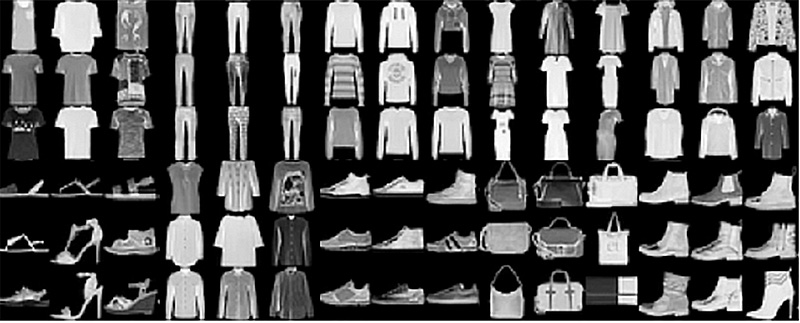

In [ ]:
(training_data, _), (_, _) = fashion_mnist.load_data()
X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
training_data[1]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

To visualize an image of the dataset you can use the following code:

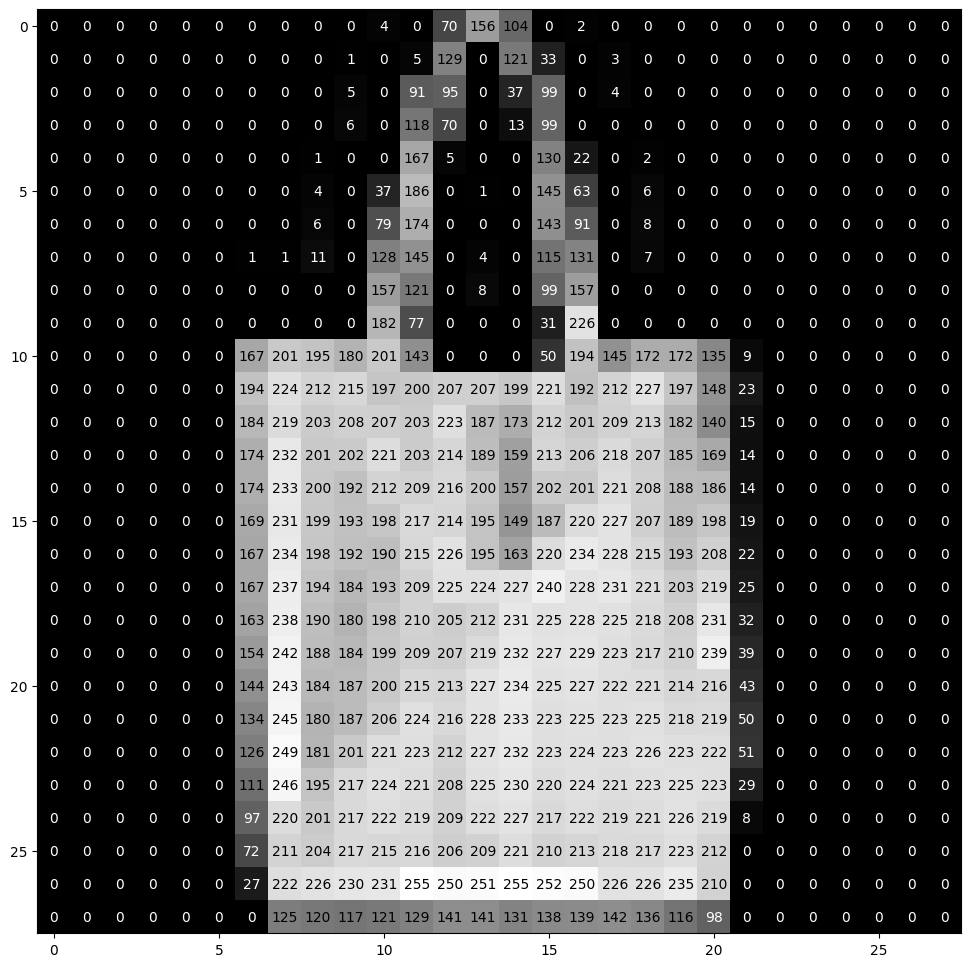

In [ ]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12))

ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

Building the Generator Model
GANs consist of two main components which are the generator and the discrimination.

 Building the generator model whose input will be a noise vector (z).



 The generator architecture is shown in the figure below.

The first layer is a fully connected layer that is then reshaped into a deep, narrow layer in the original DCGAN paper the authors reshaped the input to 4 × 4 × 1024. Here we will use 7 × 7 × 128.

Then we use the upsampling layer to double the feature map dimensions from 7 × 7 to 14 × 14 and then again to 28 × 28. In this network, we use three convolutional layers. We will also use batch normalization and a ReLU activation.

For each of these layers, the general scheme is convolution ⇒ batch normalization ⇒ ReLU. We keep stacking up layers like this until we get the final transposed convolution layer with the shape 28 × 28 × 1.

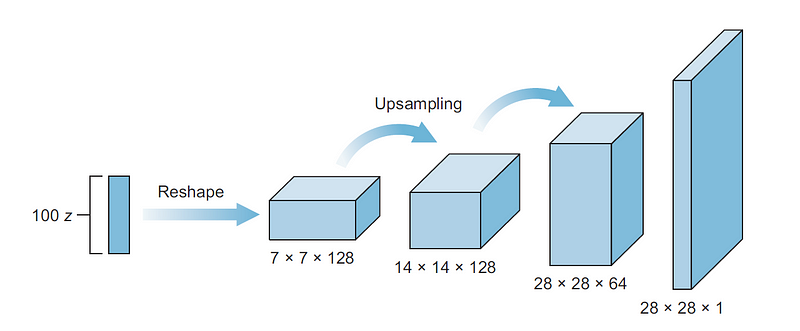



Kera’s code to build the generator model shown in the image above:

In [ ]:
def build_generator():

  generator = Sequential()

  generator.add(Dense(6272, activation="relu", input_dim=100)) # Add dense layer
  generator.add(Reshape((7, 7, 128)))  # reshape the image
  generator.add(UpSampling2D()) # Upsampling layer to double the size of the image
  generator.add(Conv2D(128, kernel_size=3, padding="same", activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(UpSampling2D())

  # convolutional + batch normalization layers
  generator.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))

  # convolutional layer with filters = 1
  generator.add(Conv2D(1, kernel_size=3, padding="same", activation="relu"))
  generator.summary() # prints the model summary

  """
  We don't add upsampling here because the image size of 28 × 28 is
  equal to the image size in the MNIST dataset.
  You can adjust this for your own problem.
  """

  noise = Input(shape=(100,))
  fake_image = generator(noise)

  # Returns a model that takes the noise vector as an input and outputs the fake image
  return Model(inputs=noise, outputs=fake_image)

Building the Discriminator Model

The second main component of the GANs is the discriminator. The discriminator is just a traditional convolution convolutional classifier.

The inputs to the discriminator are 28 × 28 × 1 images. We want a few convolutional layers and then a fully connected layer for the output.

As before, a sigmoid output is used, and we need to return the logits as well. For the depths of the convolutional layers, we can start with 32 or 64 filters in the first layer, and then double the depth as you add layers.

In this implementation, we will start with 64 layers, then 128, and then 256. For downsampling, we do not use pooling layers. Instead, we use only strided convolutional layers for downsampling, similar to Radford et al.’s implementation.

We also use batch normalization and dropout to optimize training For each of the four convolutional layers, the general scheme is convolution ⇒ batch normalization ⇒ leaky ReLU.

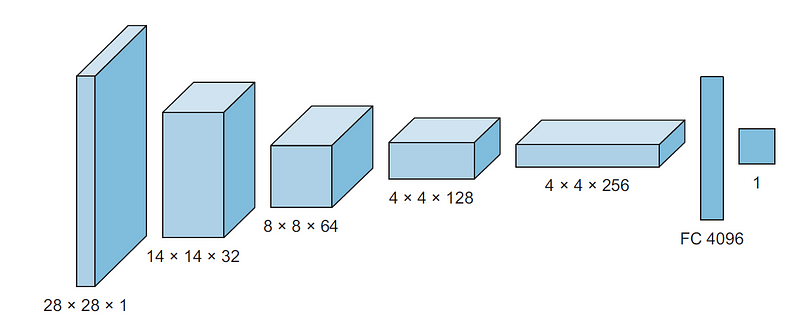

Kera's code for Discriminator model is as follows:

In [ ]:
def build_discriminator():

  discriminator = Sequential()
  discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(64, kernel_size=3, strides=2,padding="same"))
  discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
  discriminator.add(BatchNormalization(momentum=0.8))

  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))

  img = Input(shape=(28,28,1))
  probability = discriminator(img)

  return Model(inputs=img, outputs=probability)

Building the Combined Model
 to train the generator, we need to build a combined network that contains both the generator and the discriminator. The combined model takes the noise signal as input (z) and outputs the discriminator’s prediction output as fake or real.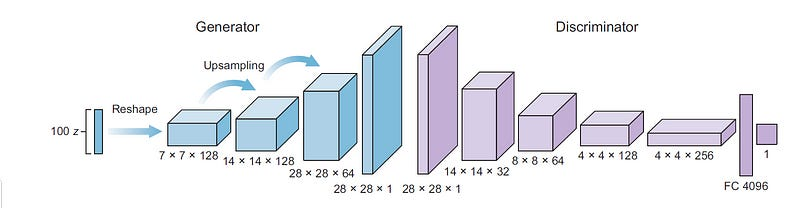

 It is important to remember that we want to disable discriminator training for the combined model. When training the generator, we don’t want the discriminator to update weights as well, but we still want to include the discriminator model in the generator training. So, we create a combined network that includes both models but freezes the weights of the discriminator model in the combined network:

In [ ]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False

# Build the generator
generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)

combined = Model(inputs=z, outputs=valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 128)      

Building the Training Function

To train the GAN model, we train two networks: the discriminator and the combined network that we created in the previous section. Let’s build the train function, which takes the following arguments:

The number of epochs
The batch size
save_interval to state how often we want to save the results

In [ ]:
def train(epochs, batch_size=128, save_interval=50):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):  # Train Discriminator network
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)


        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = combined.train_on_batch(noise, valid)

        # printing progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))

        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

We will also create another function plot_generated_images() to plot the generated images:

In [ ]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

Finally, let's define important variables and parameters for training the GAN model:

In [ ]:
# Input shape
img_shape = (28,28,1)
channels = 1
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_8 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 28, 28, 128)      

Training Function

At this point the code implementation is complete, and we are ready to start the DCGAN training. To train the model, run the following line of code. This will run the training for 1000 epochs and save images every 50 epochs. When you run the train() function, the training progress will look like the following:

1/1 [==============================] - 0s 216ms/step
0 [D loss: 0.000874, acc.: 100.00%] [G loss: 0.876319]
1/1 [==============================] - 0s 124ms/step
1 [D loss: 0.001026, acc.: 100.00%] [G loss: 0.817653]
1/1 [==============================] - 0s 118ms/step
2 [D loss: 0.006053, acc.: 100.00%] [G loss: 0.926412]
1/1 [==============================] - 0s 118ms/step
3 [D loss: 0.001185, acc.: 100.00%] [G loss: 0.902958]
1/1 [==============================] - 0s 114ms/step
4 [D loss: 0.000567, acc.: 100.00%] [G loss: 0.863336]
1/1 [==============================] - 0s 122ms/step
5 [D loss: 0.000991, acc.: 100.00%] [G loss: 0.916250]
1/1 [==============================] - 0s 116ms/step
6 [D loss: 0.001622, acc.: 100.00%] [G loss: 0.982577]
1/1 [==============================] - 0s 118ms/step
7 [D loss: 0.005814, acc.: 100.00%] [G loss: 0.744879]
1/1 [==============================] - 0s 115ms/step
8 [D loss: 0.000908, acc.: 100.00%] [G loss: 0.789632]
1/1 [=======================

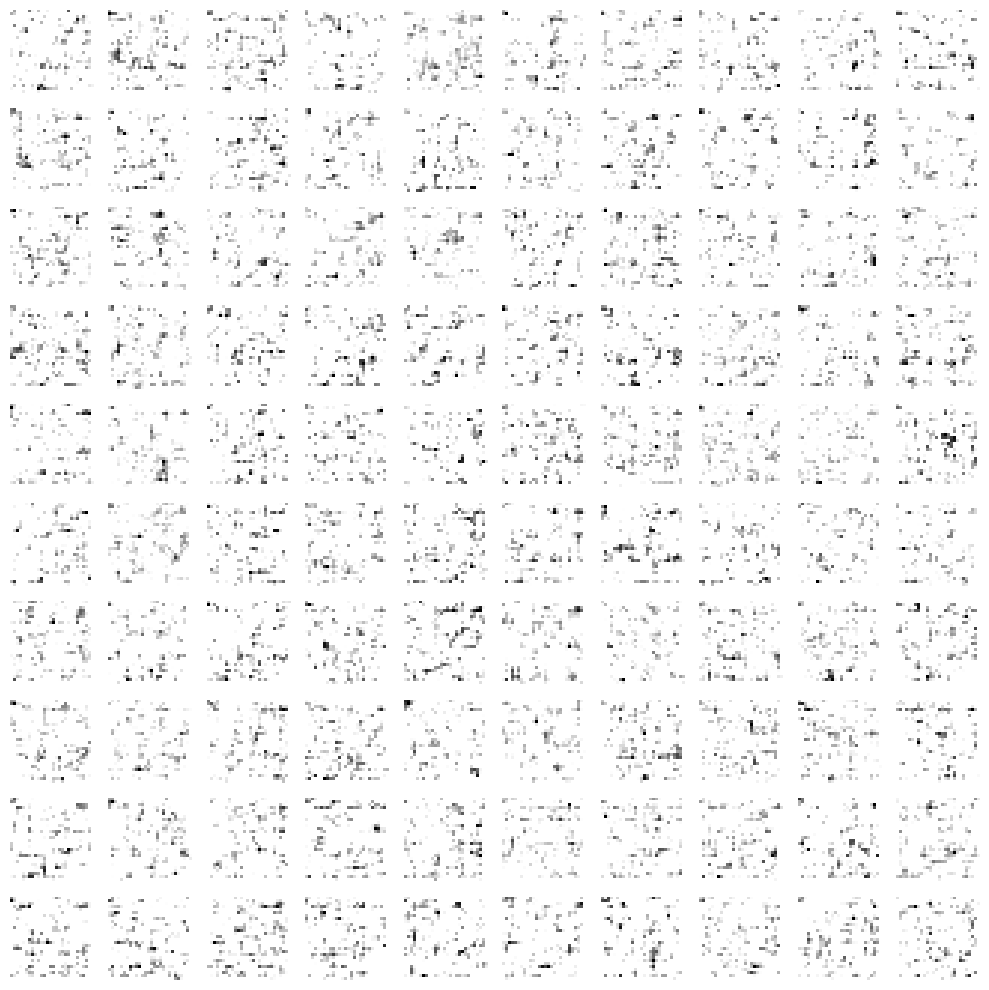

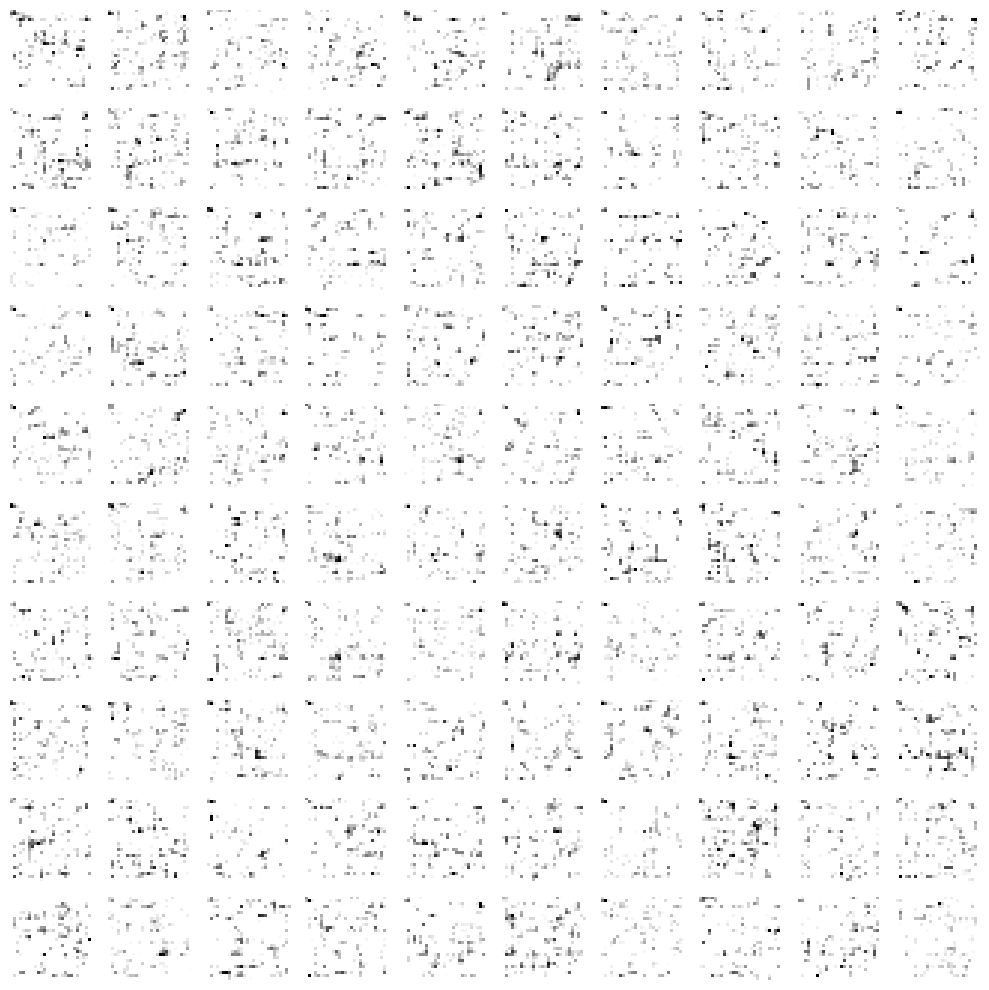

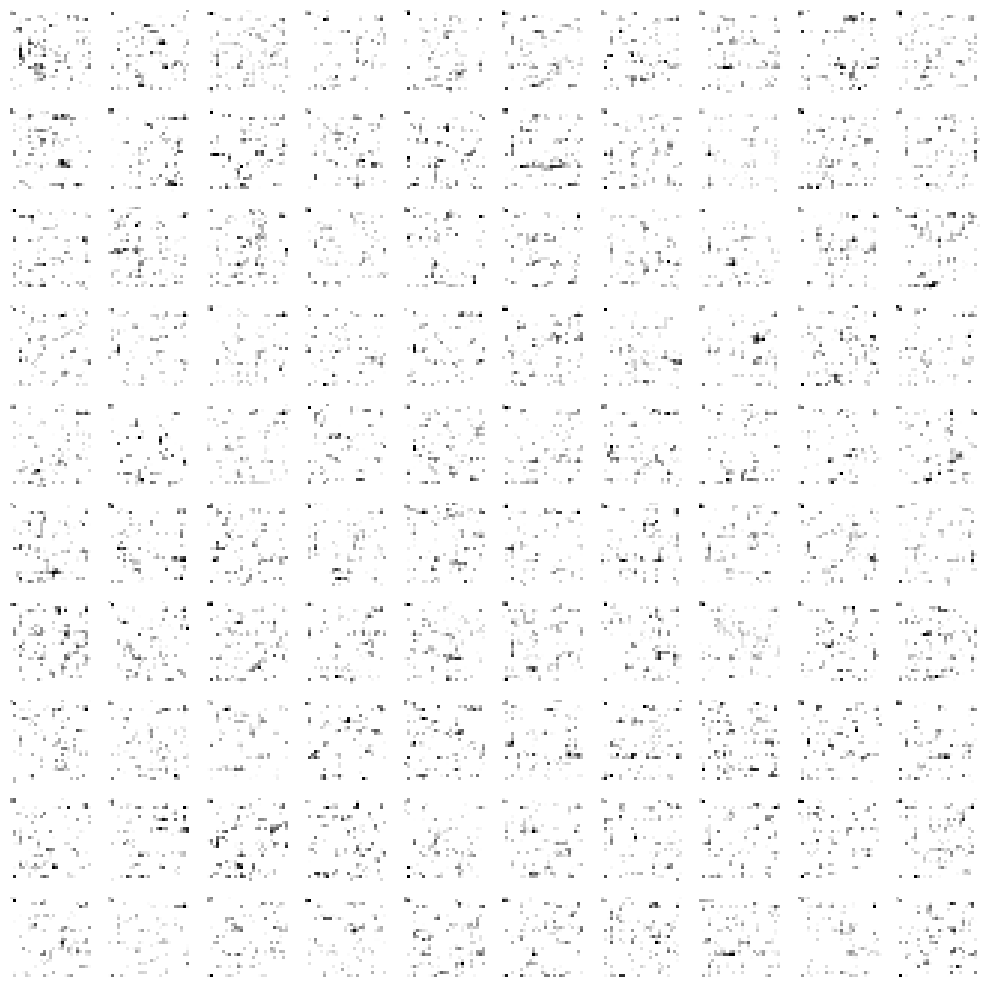

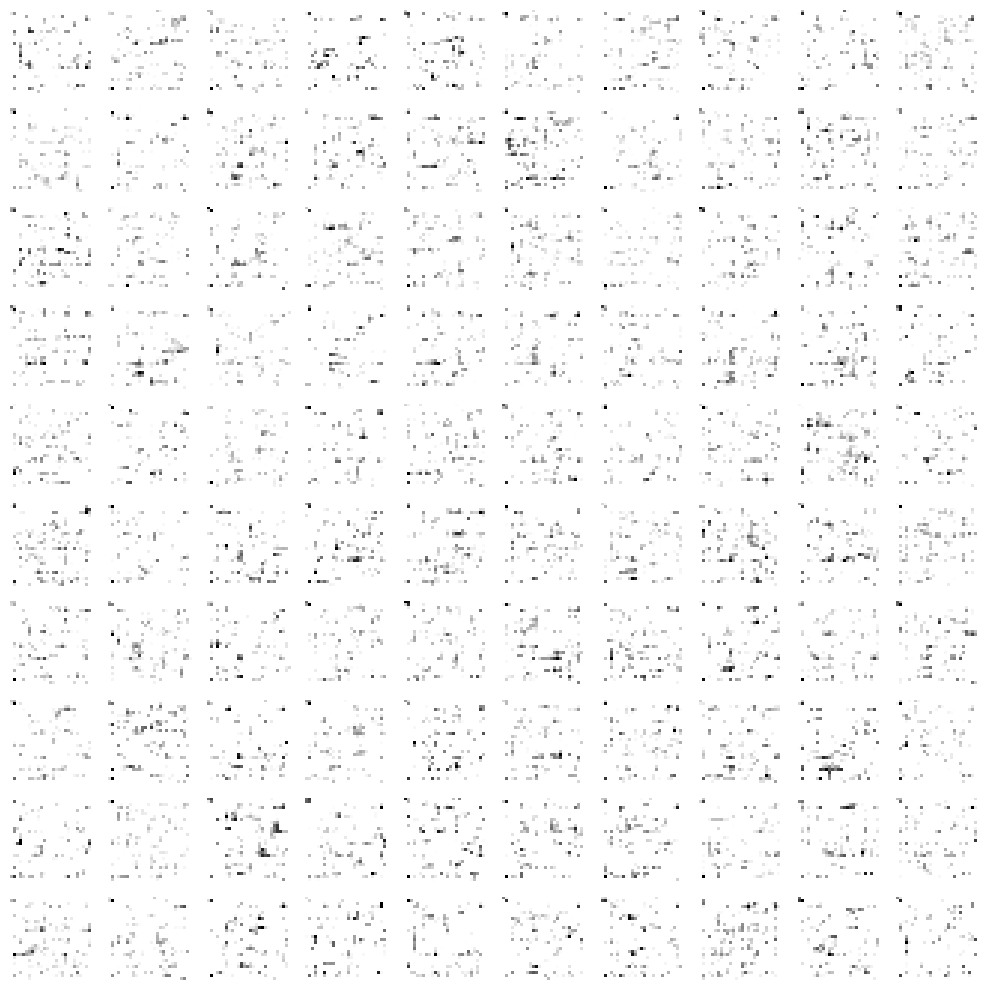

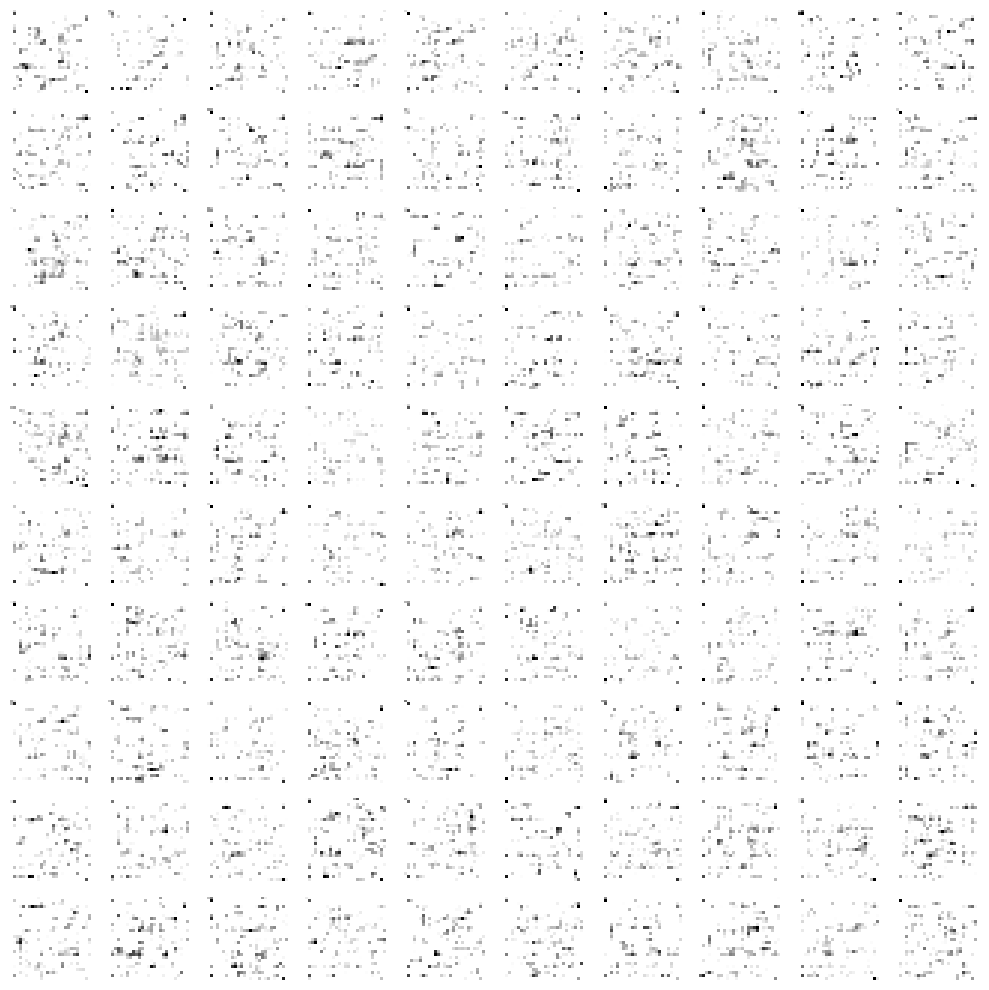

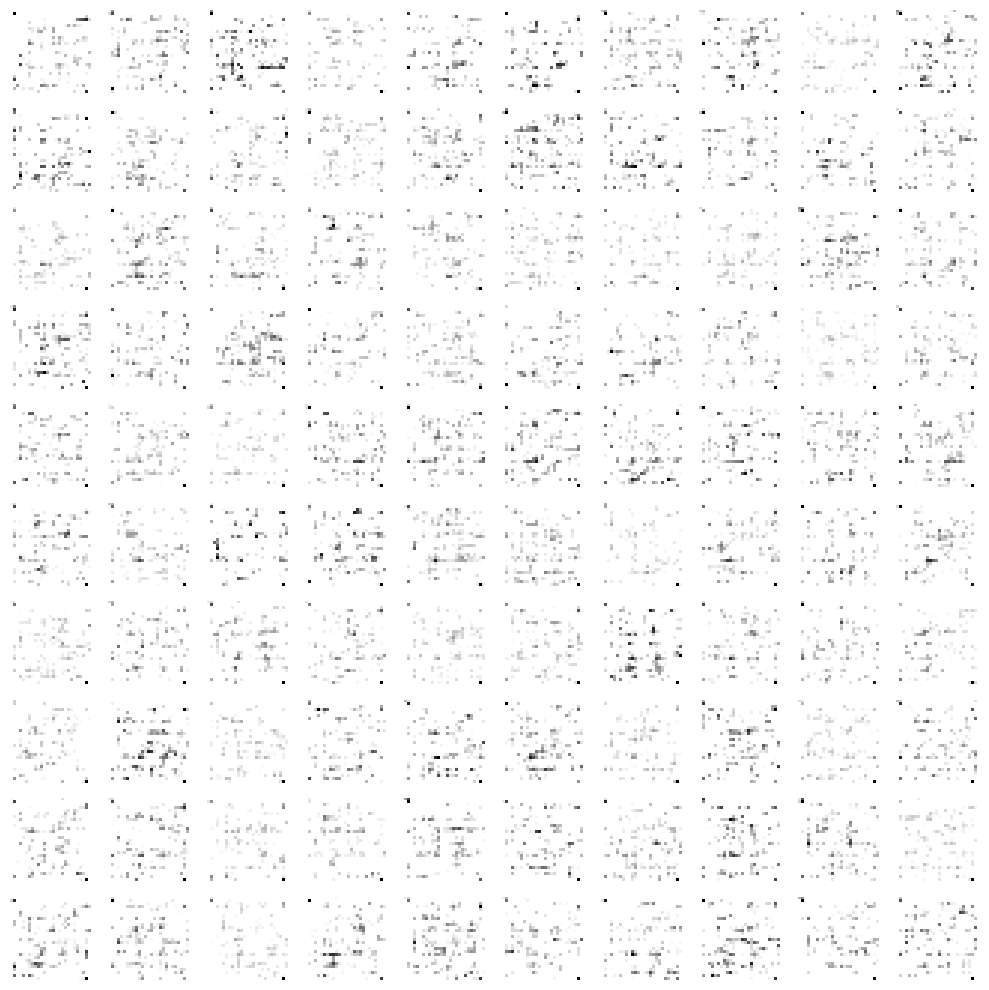

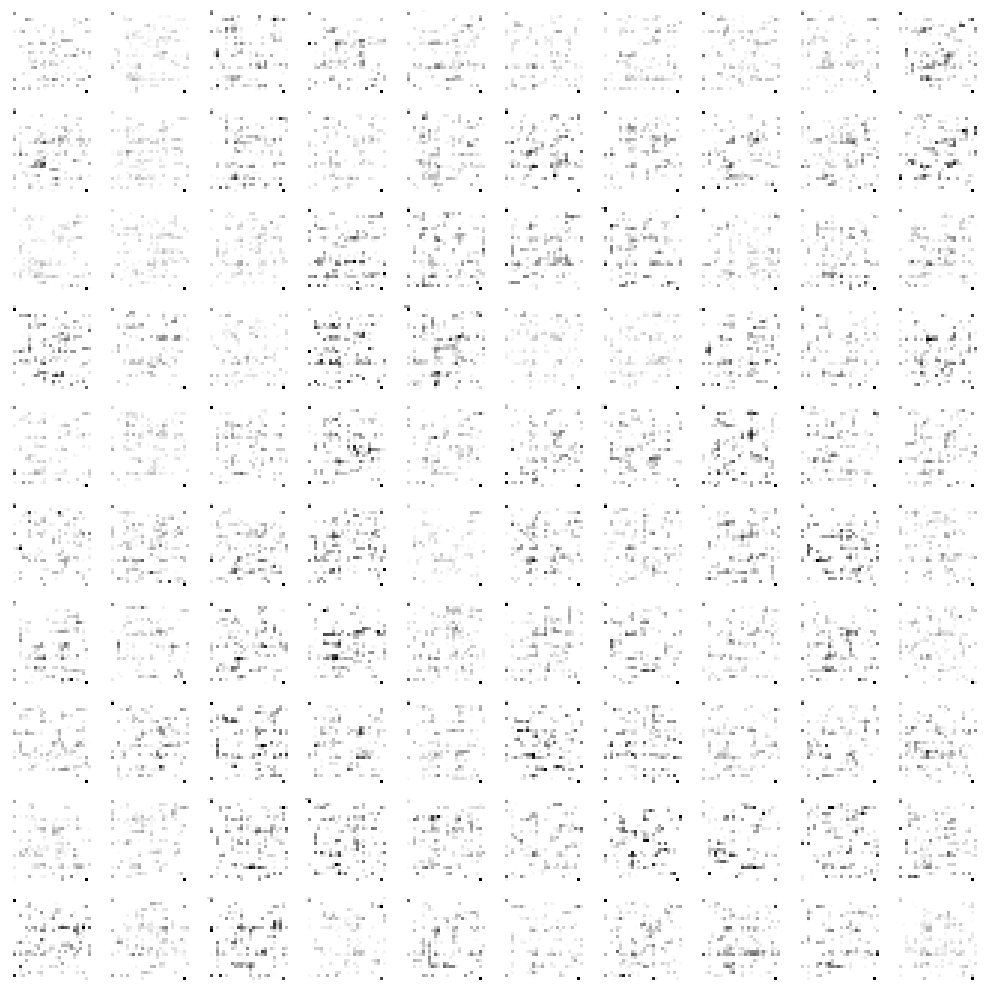

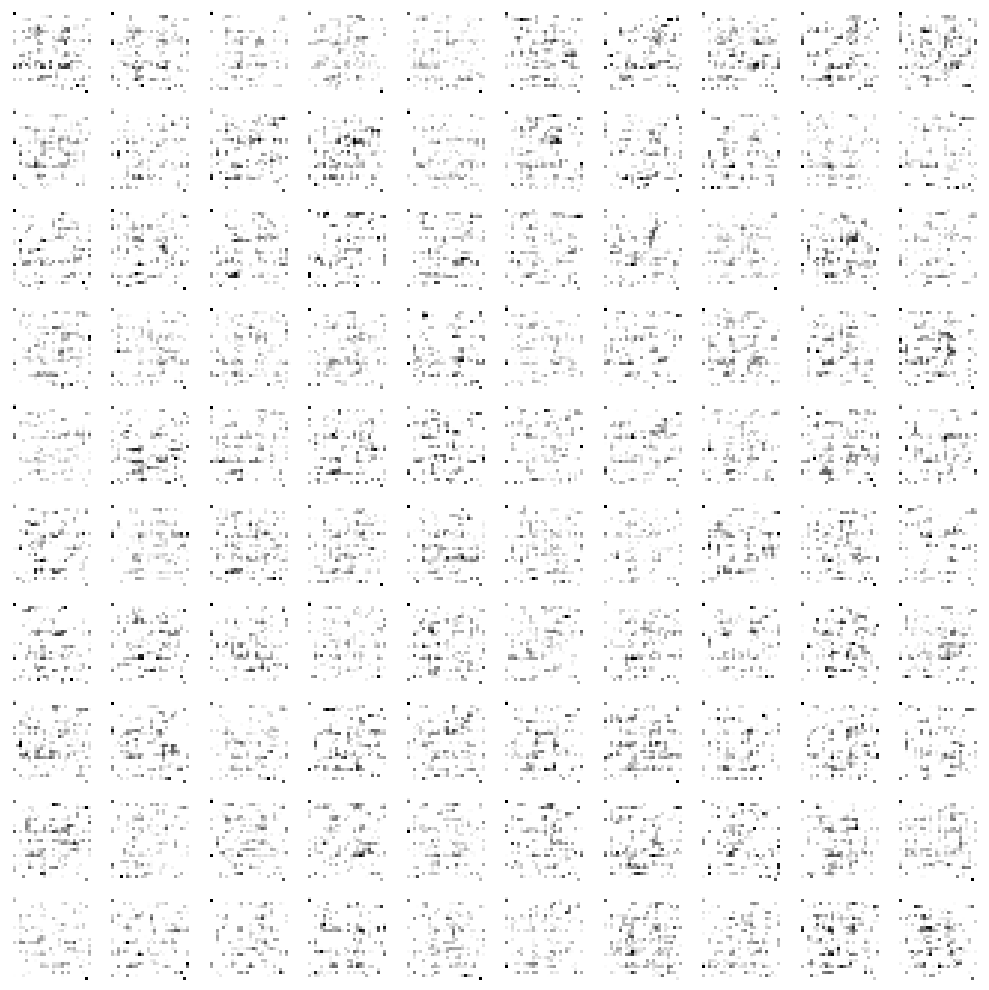

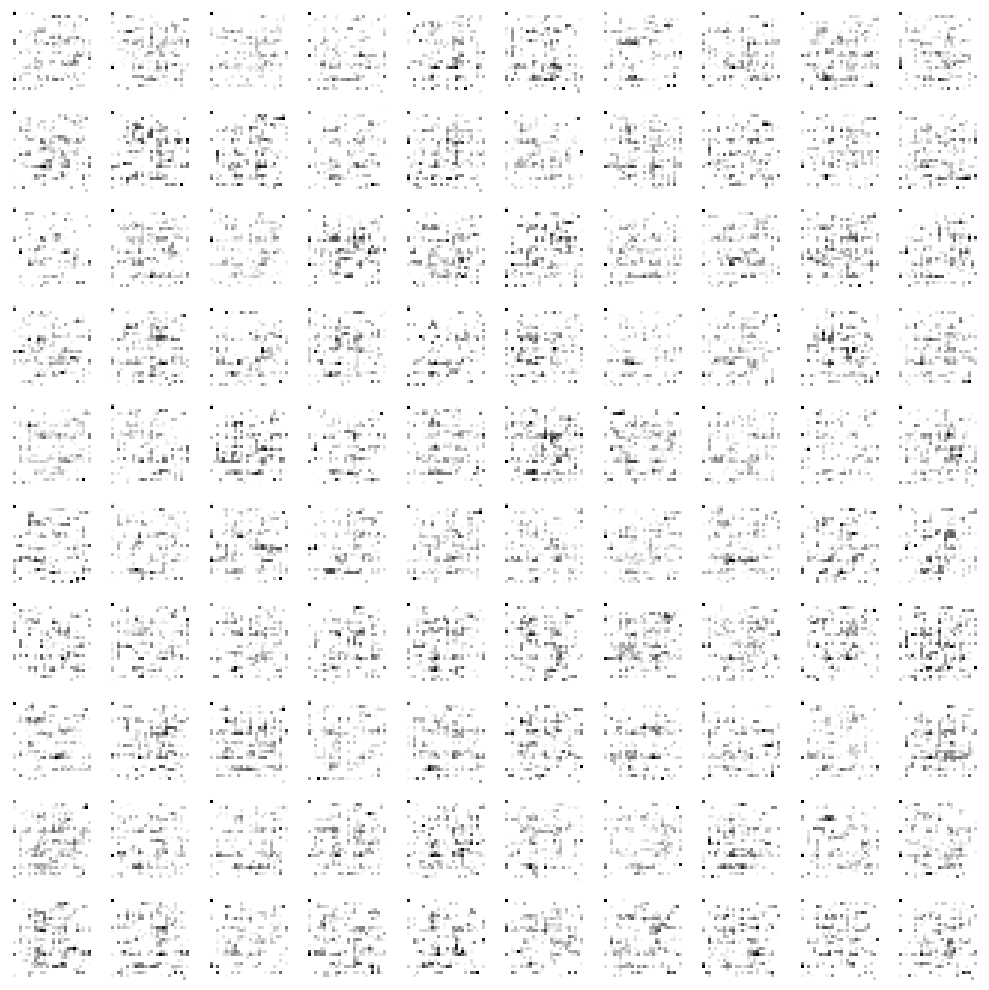

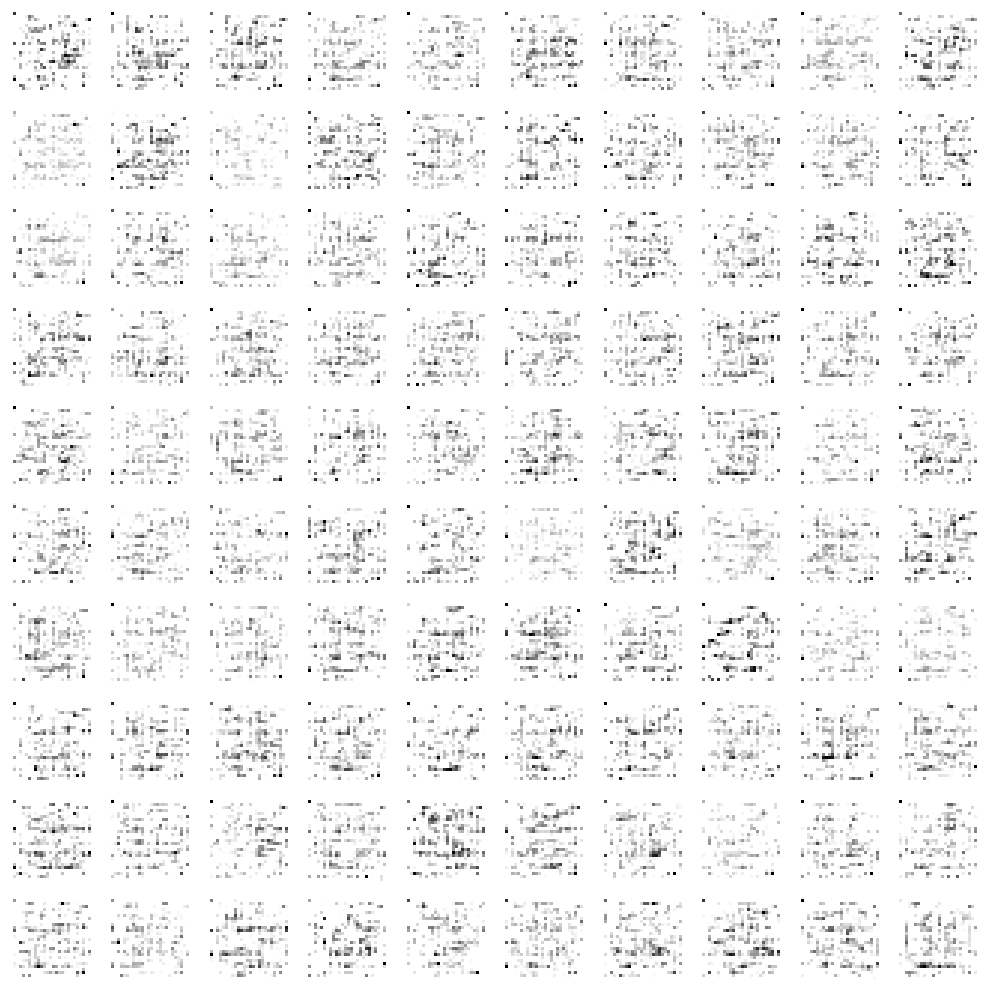

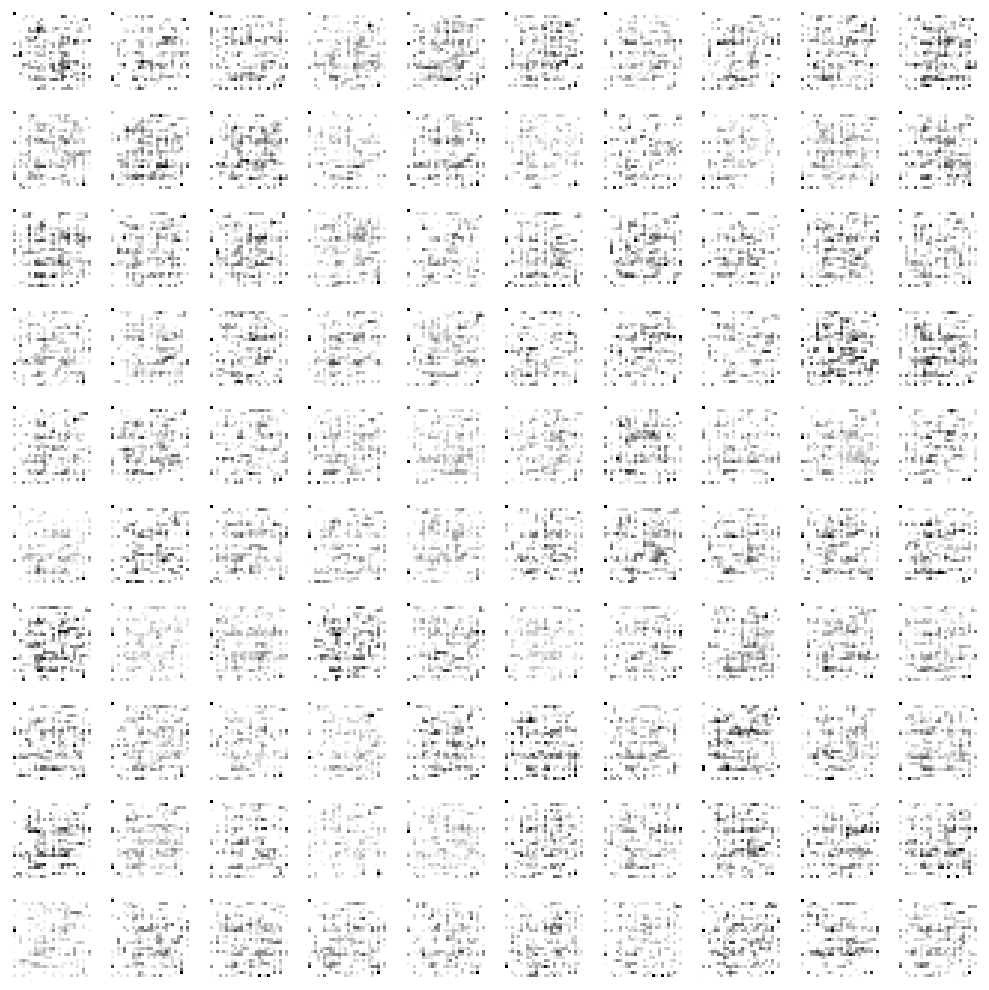

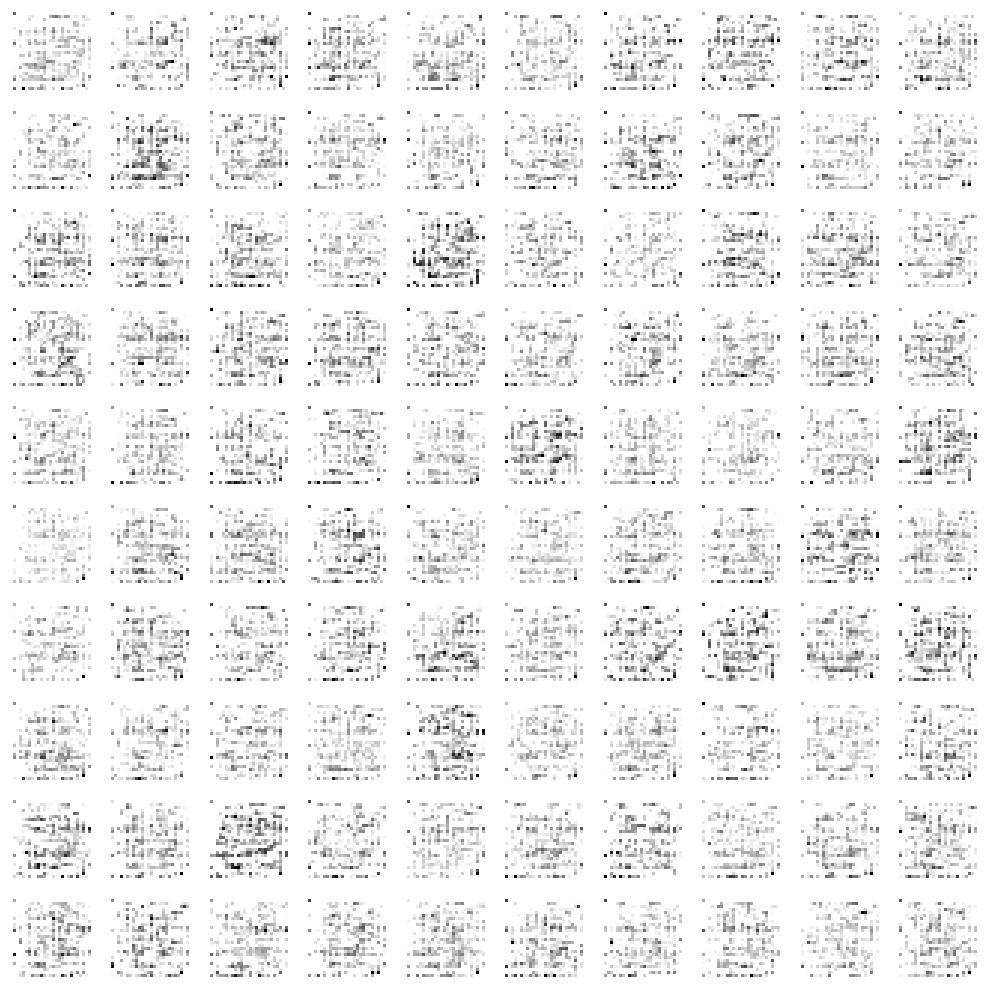

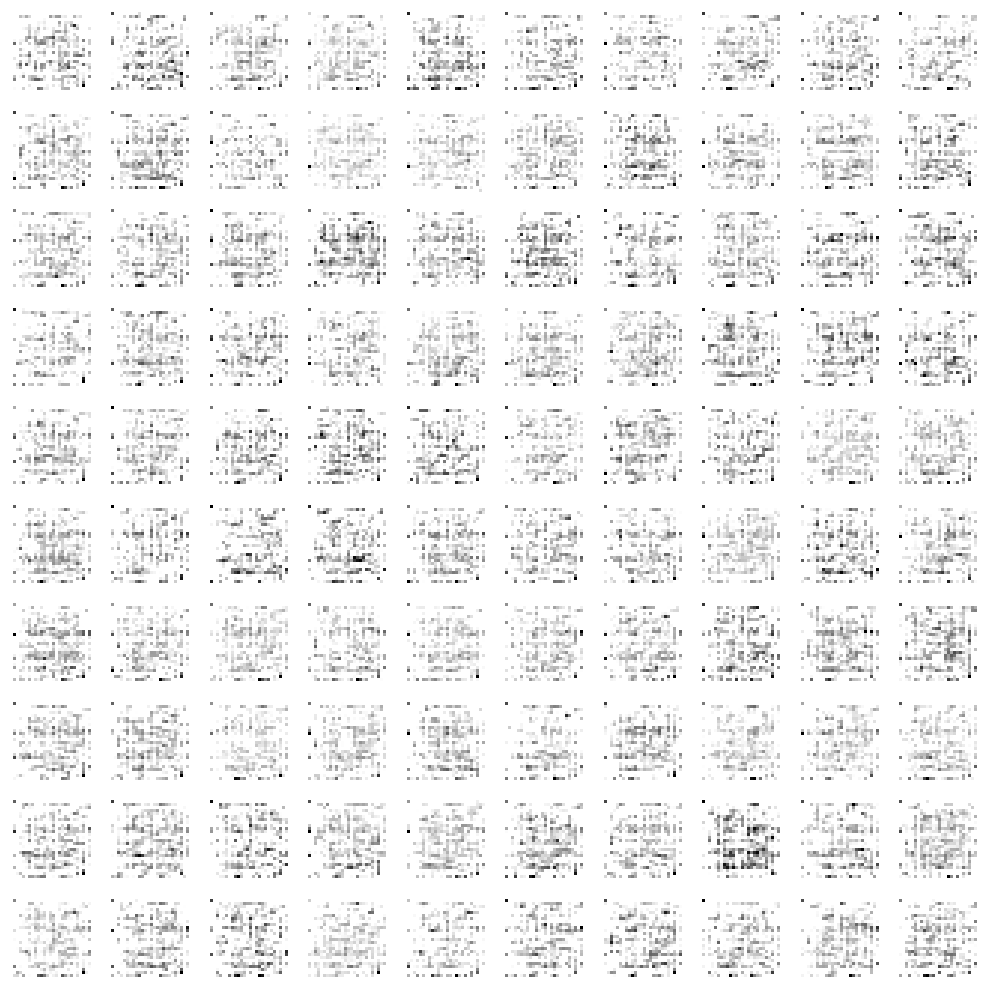

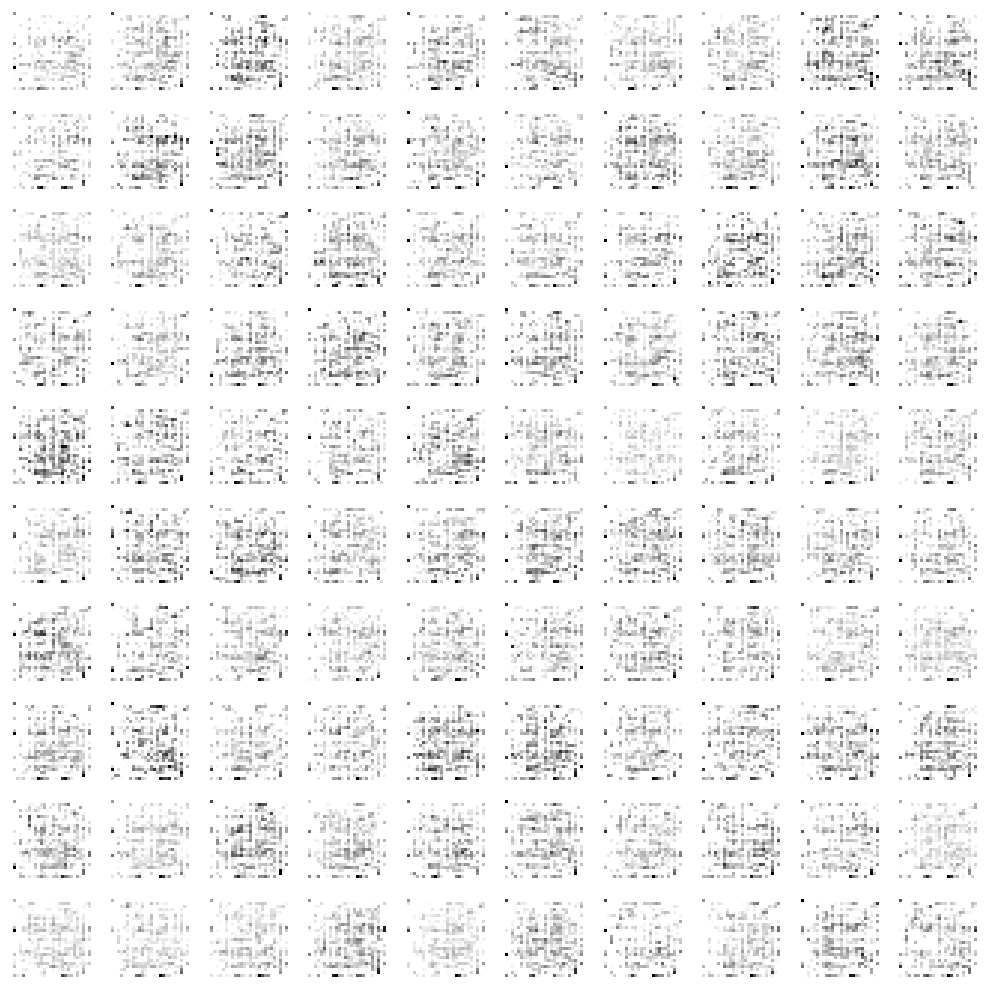

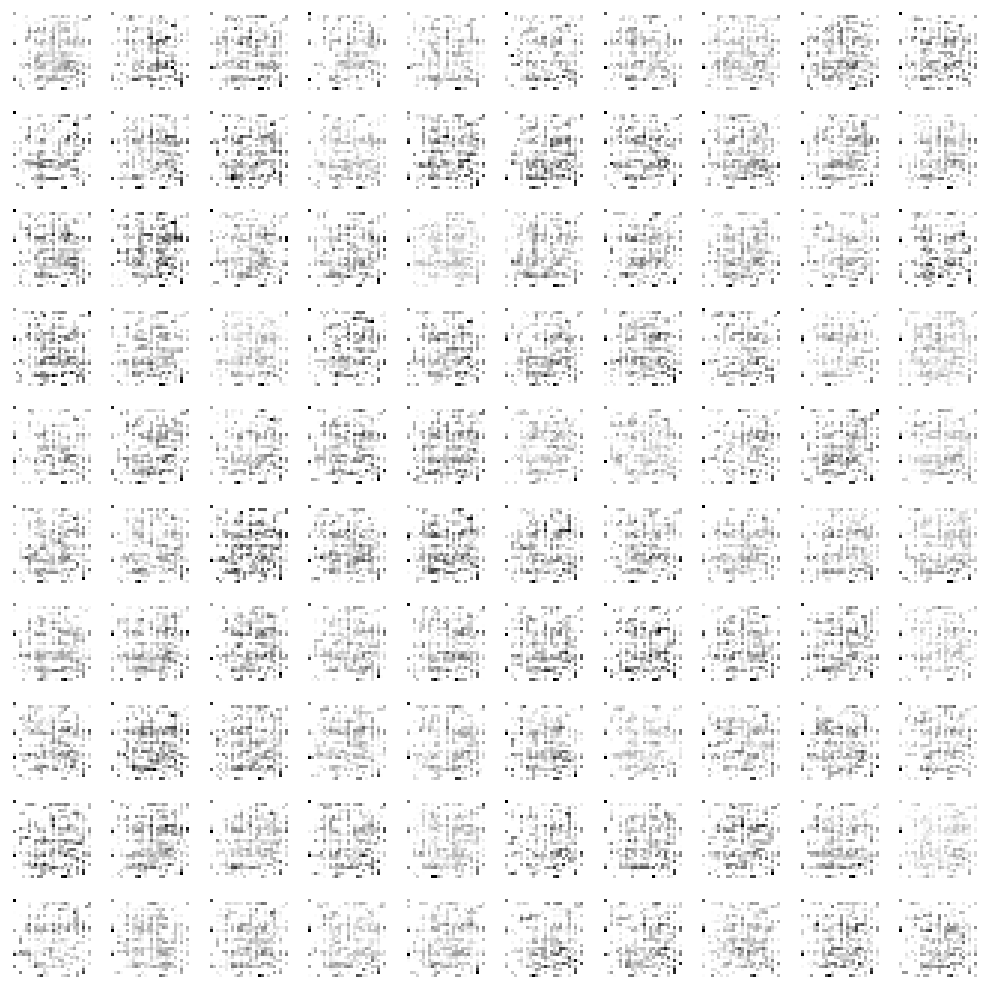

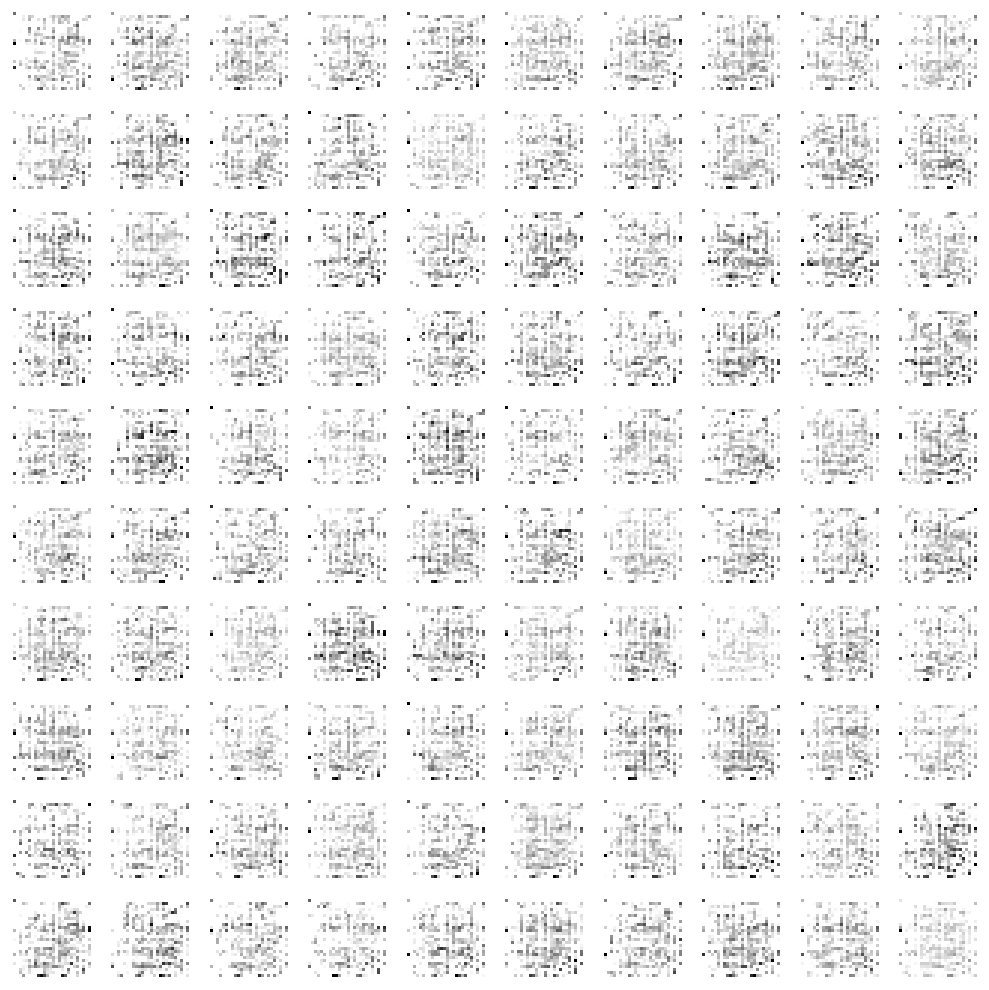

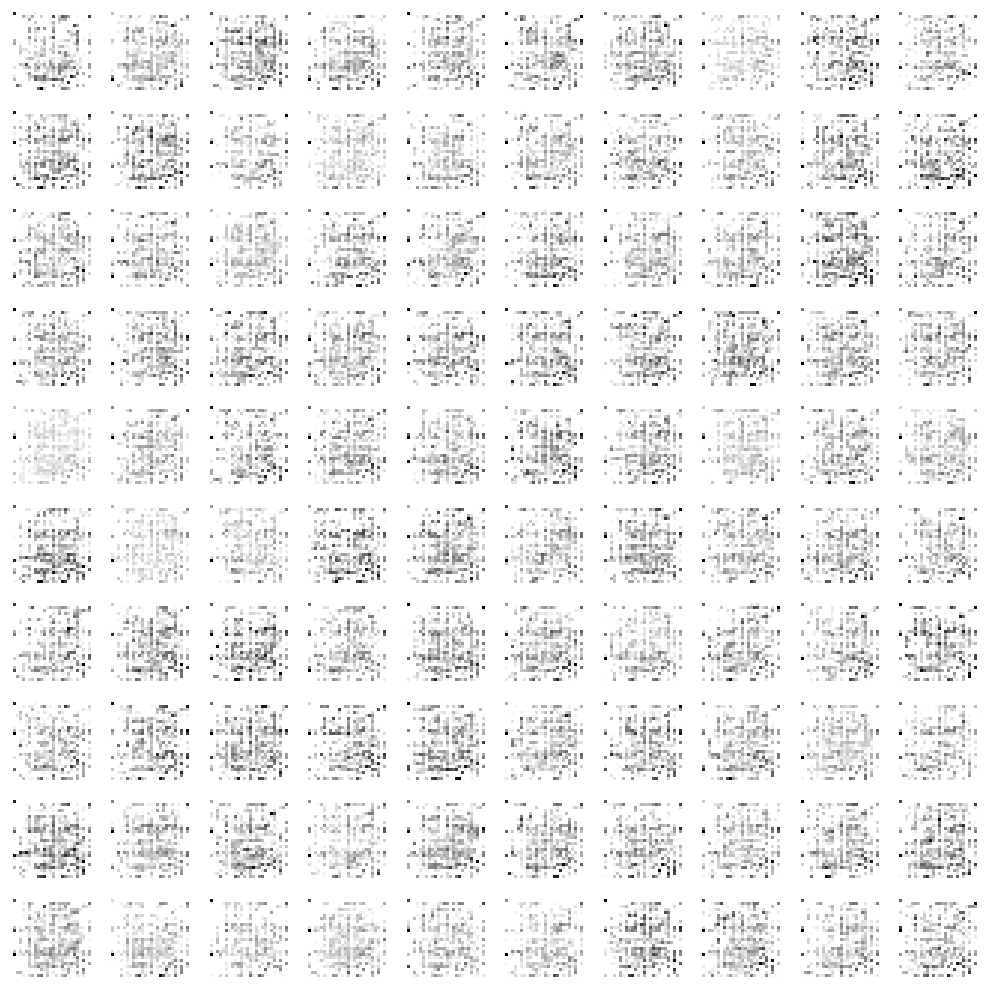

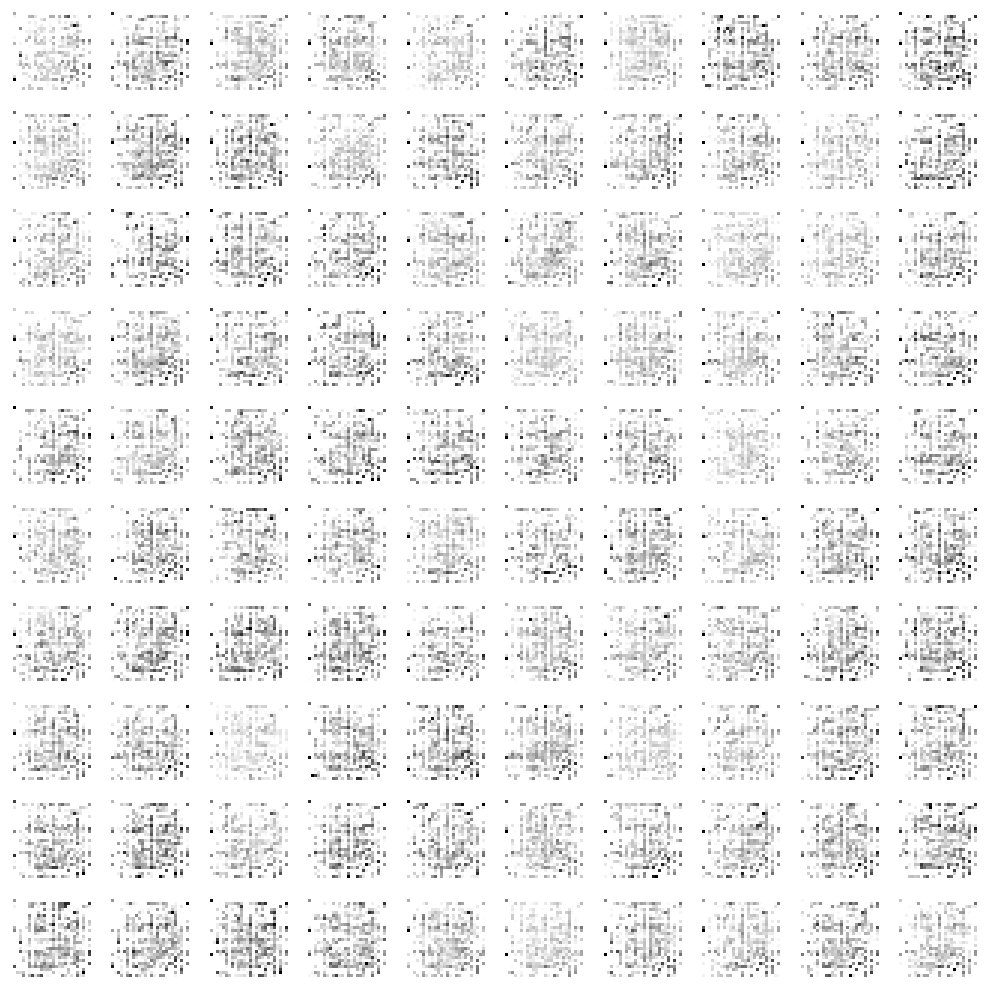

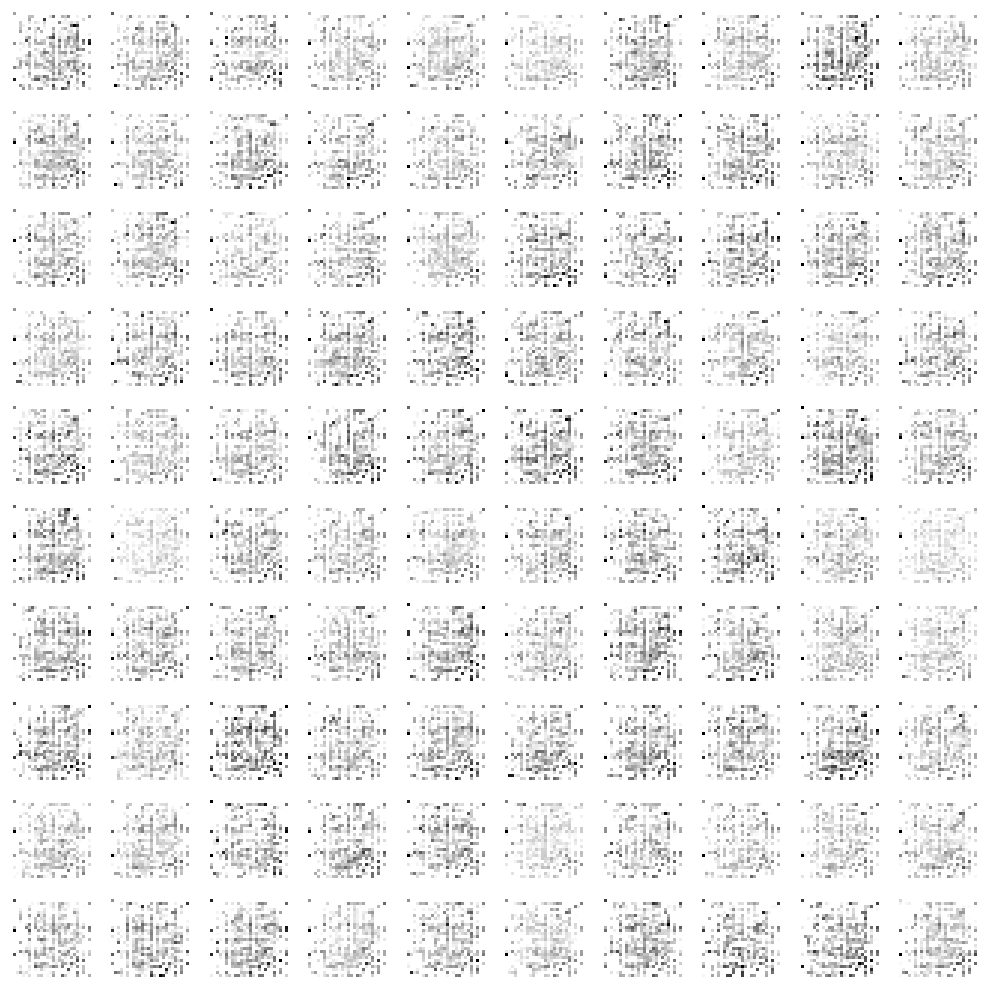

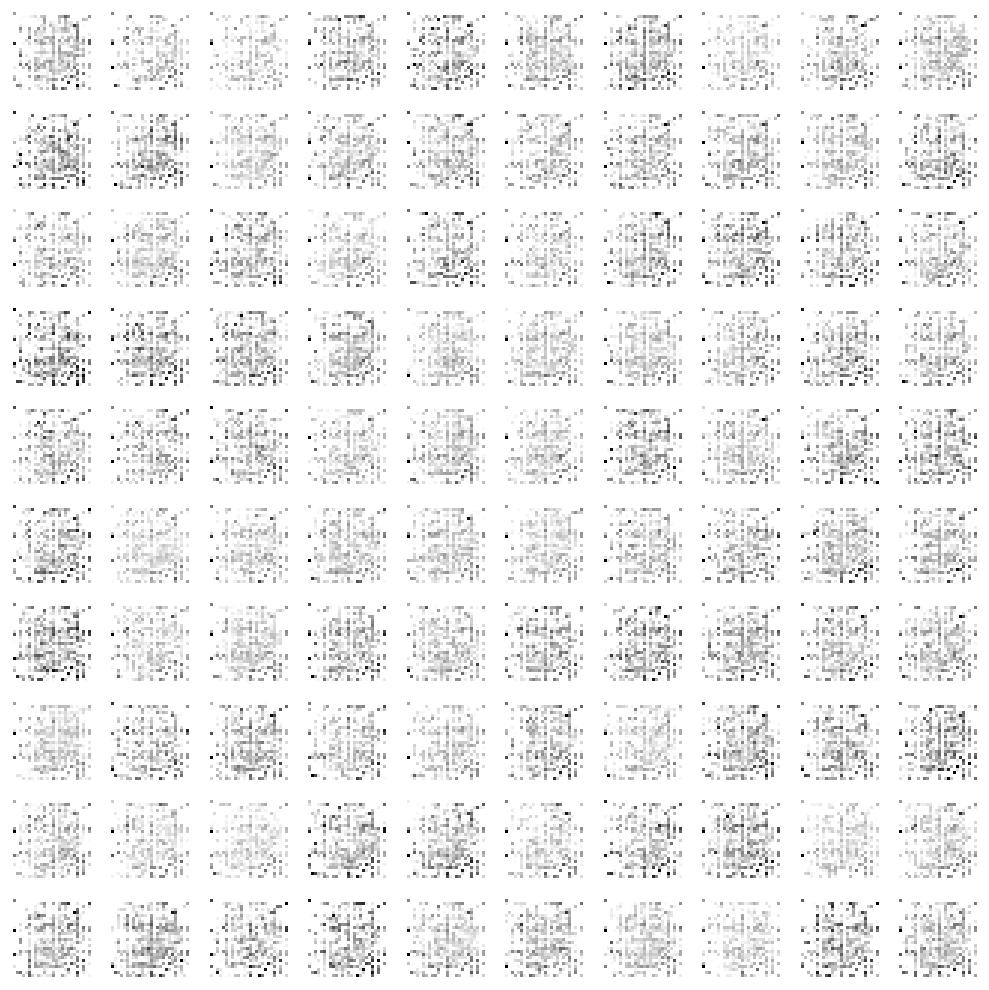

In [ ]:
train(epochs=1000, batch_size=32, save_interval=50)

As you can see below, at epoch 0, the images are just random noise with no certain patterns or meaningful data. At epoch 50, patterns have started to form. Later in the training process, at epoch 1,000, you can see clear shapes and can probably guess the type of training data fed to the GAN model. Fast-forward to epoch 10,000, and you can see that the generator has become very good at re-creating new images not present in the training dataset.